In [12]:
%cd working

/kaggle/working


In [1]:
!huggingface-cli login --token ''

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [17]:
data = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [18]:
data.set_index('Month')
data = data.squeeze()
type(data)

pandas.core.frame.DataFrame

In [19]:
train, test = data['#Passengers'][:int(0.7*len(data))], data['#Passengers'][int(0.7*len(data)):]
len(train), len(test)

(100, 44)

In [2]:
!pip install transformers bitsandbytes>=0.39.0 -q
!pip install accelerate

In [3]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
import os
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KernelDensity

os.environ["HUGGINGFACEHUB_API_TOKEN"] = ''

In [4]:
@dataclass
class Scaler:
    transform: callable = lambda x: x
    inv_transform: callable = lambda x: x

In [5]:
model_cache = {}

In [6]:
class LLMTime:

    def __init__(self, train, test, alpha=0.95, beta=0.3, batch_length=400, basic=False, temperature=0.5, do_sample=True, model_name="mistralai/Mistral-7B-v0.1", repetition_penalty=1.0, all_in_one=False, pretrain=False, load_in_4bit=True, num_samples=10):
        self.model_name = model_name
        self.train = train
        self.test = test
        self.alpha = alpha
        self.beta = beta
        self.batch_length = batch_length
        self.basic = basic
        self.temperature = temperature
        self.do_sample = do_sample
        self.repetition_penalty = repetition_penalty
        self.scalers = None
        self.input_str = None
        self.test_str = None
        self.tokenizer = None
        self.model = None
        self.good_tokens = None
        self.bad_tokens = None
        self.output = None
        self.transformed_output_arr = None
        self.all_in_one = all_in_one
        self.pretrain = pretrain
        self.load_in_4bit = load_in_4bit
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_samples = num_samples
        self.preprocess_data()

    @staticmethod
    def get_scaler(history, alpha=0.95, beta=0.3, basic=False):
        history = history[~np.isnan(history)]
        if basic:
            q = np.maximum(np.quantile(np.abs(history), alpha),.01)
            def transform(x):
                return x / q
            def inv_transform(x):
                return x * q
        else:
            min_ = np.min(history) - beta*(np.max(history)-np.min(history))
            q = np.quantile(history-min_, alpha)
            if q == 0:
                q = 1
            def transform(x):
                return (x - min_) / q
            def inv_transform(x):
                return x * q + min_
        return Scaler(transform=transform, inv_transform=inv_transform)

    def convert_array_to_string(self, arr):
        rounded_values = [round(val * 1000) for val in arr]
        str_values = [str(val) for val in rounded_values]
        result_string = ",".join(str_values)
        return result_string

    def preprocess_data(self):
        train = self.train
        test = self.test
        if not isinstance(train, list):
            train = [train]
            test = [test]
        n_val = len(train)
        for i in range(len(train)):
            if not isinstance(train[i], pd.Series):
                train[i] = pd.Series(train[i], index=pd.RangeIndex(len(train[i])))
                test[i] = pd.Series(test[i], index=pd.RangeIndex(len(train[i]), len(test[i])+len(train[i])))
        alpha = self.alpha
        beta = self.beta
        basic = self.basic
        self.scalers = [self.get_scaler(train[i].values, alpha=alpha, beta=beta, basic=basic) for i in range(len(train))]
        input_arrs = [train[i].values for i in range(len(train))]
        transformed_input_arrs = np.array([scaler.transform(input_array) for input_array, scaler in zip(input_arrs, self.scalers)])
        input_str = self.convert_array_to_string(transformed_input_arrs[0])
        test_arrs = [test[i].values for i in range(len(test))]
        transformed_test_arrs = np.array([scaler.transform(input_array) for input_array, scaler in zip(test_arrs, self.scalers)])
        test_str = self.convert_array_to_string(transformed_test_arrs[0])
        self.input_str = input_str
        self.test_str = test_str
        return input_str, test_str, self.scalers

    def zero_shot(self):
        input_str = self.input_str
        if model_cache.get(self.model_name) is not None:
            self.model = model_cache[self.model_name][0]
            self.tokenizer = model_cache[self.model_name][1]
        else:
            self.model = AutoModelForCausalLM.from_pretrained(self.model_name, device_map='auto')
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, padding_side="left")
            model_cache[self.model_name] = [self.model, self.tokenizer]
        good_tokens_str = list("0123456789,")
        good_tokens = [self.tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
        bad_tokens = [i for i in range(len(self.tokenizer)) if i not in good_tokens]
        if self.pretrain:
            for i in range(self.batch_length, len(input_str) - self.batch_length//10, self.batch_length//10):
              print(i)  
              batch_str = input_str[i-self.batch_length: i]
              model_inputs = self.tokenizer(batch_str, return_tensors='pt').to(self.device)
              generated_ids = self.model.generate(**model_inputs, do_sample=True, max_new_tokens=self.batch_length//10, min_new_tokens=self.batch_length//10,temperature=self.temperature, repetition_penalty=self.repetition_penalty, bad_words_ids=[[t] for t in bad_tokens])
              output = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        if self.all_in_one:
            batch_str = input_str[-self.batch_length:]
            model_inputs = self.tokenizer(batch_str, return_tensors='pt').to(self.device)
            generated_ids = self.model.generate(**model_inputs, do_sample=True, max_new_tokens=self.batch_length//10, min_new_tokens=self.batch_length//10,temperature=self.temperature, repetition_penalty=self.repetition_penalty, bad_words_ids=[[t] for t in bad_tokens])
            output = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            output = output[len(batch_str):]
            self.output = output
            return output

        inp = input_str[-self.batch_length:]
        out = ""
        k = max(1, len(self.test_str)//(self.batch_length//10))
        for i in range(k):
            print(i)
            model_inputs = self.tokenizer(inp, return_tensors='pt').to(self.device)
            generated_ids = self.model.generate(**model_inputs, do_sample=True, max_new_tokens=self.batch_length//10, min_new_tokens=self.batch_length//10,temperature=self.temperature, repetition_penalty=self.repetition_penalty, bad_words_ids=[[t] for t in bad_tokens])
            output = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            output = output[len(inp):]
            out += output
            inp += output
            inp = inp[-self.batch_length:]
        self.output = out
        return out

    @staticmethod
    def invert_string_to_array(string_values):
        string_values = string_values.replace(" ", "")
        if string_values[-1] == ',':
            string_values = string_values[:len(string_values) - 1]
        str_values_list = string_values.split(',')
        float_values = [float(val) if val.strip() != '' else 0.0 for val in str_values_list]
        original_values = [val / 1000 for val in float_values]
        return original_values

    def get_original_array(self, output_str):
        output_arr = self.invert_string_to_array(string_values=output_str)
        output_arr = np.array(output_arr)
        transformed_output_arr = self.scalers[0].inv_transform(output_arr)
        self.transformed_output_arr = transformed_output_arr
        return transformed_output_arr

    def plot(self, input, outputs, m):
      model_parameters = {
          "alpha": self.alpha,
          "beta": self.beta,
          "batch_length": self.batch_length,
          "basic": self.basic,
          "temperature": self.temperature,
          "do_sample": self.do_sample,
          "repetition_penalty": self.repetition_penalty,
          "all_in_one": self.all_in_one,
          "pretrain": self.pretrain,
          "load_in_4bit": self.load_in_4bit,
          "num_samples": self.num_samples
      }

      sns.set(style="whitegrid")
      fig, ax = plt.subplots(figsize=(10, 6))
      plt.title(f"Zero Shot {self.model_name}")
      plt.axvline(x=m, color='k', linestyle='--', label='Train-Test Split')

      # Plot minimum, maximum, and median of the outputs
      min_output = np.min(outputs, axis=0)
      max_output = np.max(outputs, axis=0)
      median_output = np.median(outputs, axis=0)
      mean_output = np.mean(outputs, axis=0)

      for i in range(len(outputs)):
        plt.plot(outputs[i], color='darkgray', alpha=0.5, label='_nolegend_')

      plt.plot(min_output, color='green', linestyle='--', label='Min Predicted')
      plt.plot(max_output, color='orange', linestyle='--', label='Max Predicted')
      plt.plot(median_output, color='red', label='Median Predicted')
      plt.plot(mean_output, color='violet', label='Mean Predicted')

      plt.plot(input, color='blue', label='Actual')
      plt.legend()

      plt.grid(True)
      plt.xlabel('Time')
      sns.set_palette("husl")

      mae = mean_absolute_error(input[-(len(input)-m):], median_output[-(len(median_output)-m):])
      rmse = np.sqrt(mean_squared_error(input[-(len(input)-m):], median_output[-(len(median_output)-m):]))
      input_range = np.max(input) - np.min(input)
      input_std = np.std(input)

    # Scale MAE and RMSE
      scaled_mae = mae / input_range
      scaled_rmse = rmse / input_std
      std_dev = np.std(outputs, axis=0)

      # Display MAE, RMSE, and standard deviation on the graph
      error_text = f"\n\nMedian MAE: {mae:.2f}\nMedian RMSE: {rmse:.2f}\nStandard Deviation: {np.mean(std_dev):.2f}\nScaled Median MAE: {scaled_mae:.2f}\nScaled Median RMSE: {scaled_mse:.2f}"
      ax.text(1.05, 0.4, error_text, transform=ax.transAxes, fontsize=10, verticalalignment='center')

      # Display model parameters
      textstr = '\n'.join([f"{key}: {value}" for key, value in model_parameters.items()])
      props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
      ax.text(1.05, 0.6, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=props)

      model_name = self.model_name.split('/')[1]
      current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
      random_number = np.random.randint(0, 1000)
      filename = f"{model_name}-zero-shot-{current_time}-{random_number}.png"

      plt.savefig(filename, dpi=300, bbox_inches='tight')
      print(f"Plot saved as {filename}")


    def run(self):
        outputs = []
        for i in range(self.num_samples):
            output = self.zero_shot()
            outputs.append(output)
        r = np.array(outputs)
        self.plot_and_return(outputs)
        return outputs

    def plot_and_return(self, outputs):
      l = []
      for i, output in enumerate(outputs):
        firstCommaIndex = output.find(',')
        lastCommaIndex = output.rfind(',')
        outputs[i] = output[firstCommaIndex+1:lastCommaIndex]
      input_arr = self.get_original_array(self.input_str + ',' + self.test_str)
      inp = self.get_original_array(self.input_str)
      m = len(inp)
      min_len = 9999999999
      for i, output in enumerate(outputs):
        transformed_output_arr = self.get_original_array(self.input_str + ',' + output)
        min_len = min(min_len, len(transformed_output_arr))
        l.append(transformed_output_arr)
      input_arr = input_arr[:min_len]
      for i, x in enumerate(l):
        l[i] = x[:min_len]
      self.plot(input_arr, np.array(l), m)

In [82]:
llm = LLMTime(train,
              test,
              alpha=1,
              beta=1,
              batch_length=2000,
              basic=False,
              temperature=0.8,
              do_sample=True,
              model_name="google/gemma-2b",
              repetition_penalty=1.3,
              all_in_one=False,
              pretrain=False,
              load_in_4bit=True,
              num_samples=10)

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
Plot saved as gemma-2b-zero-shot-2024-03-23_11-58-32-555.png


['890,911,1138,1239,946,909,1005,934,949,1015,1063,1000,1130,1190,1298,1108,984,1044,1151,1130,1140,1269,1392,1177,1038,908,1192,1210,1329,1264,1334',
 '701,549,536,655,647,527,536,536,721,687,754,682,552,524,524,737,681,584,612,603,508,497,637,637,573,641,642,758,874,988,1000,1133,1252,1213,1162',
 '858,913,815,599,456,505,576,572,609,605,671,734,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759,759',
 '854,793,830,1000,873,816,675,578,494,543,650,723,678,1000,773,710,625,515,455,543,605,726,638,855,869,781,842,1000,686,647,557,420,366,433,558,619',
 '760,680,587,656,689,678,752,731,701,896,948,1016,1048,926,686,559,624,652,676,751,733,786,882,990,1073,971,772,687,837,853,896,918,986,967,933,908',
 '804,806,535,445,439,434,461,369,277,278,315,315,302,258,239,287,259,334,334,334,454,446,454,504,545,525,539,600,630,648,855,1019,943,750,750,813,823',
 '799,765,772,590,590,805,632,954,1146,974,921,827,903,699,662,985,1089,1025,929,977,1162,118

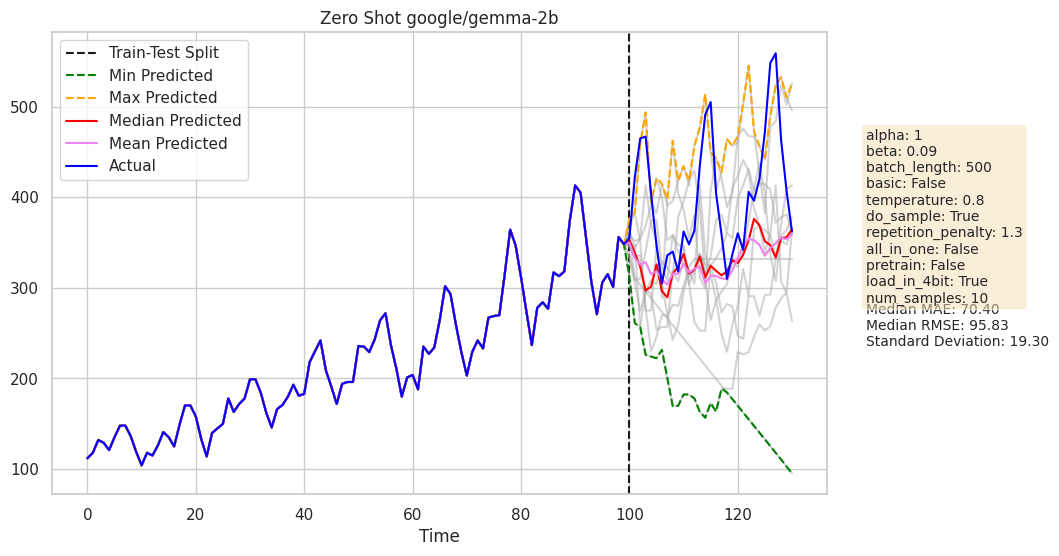

In [83]:
llm.run()